In [1]:
# zstandard needs to be imported before graph_tool!!
import zstandard
import graph_tool.all as gt

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pickle

from pygenstability import plotting
from pygenstability.contrib.optimal_scales import *

# Setup MSF

In [3]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from msfiltration import MSF
from msfiltration.msf_bootstrapping import plot_pds, select_scales_pds, msf_bootstrap

In [4]:
# Set MS parameters
n_time = 200
min_time = -1.5
max_time = 0.5

In [5]:
# number of bootstraps
B = 20
# number of samples for each bootstrap
n_sample = 150

# Load real network

In [6]:
# Load network with gt
G_gt = gt.collection.ns["wiki_science"]

# Extract LCC
G_gt = gt.extract_largest_component(G_gt)

# Get sparse adjacency matrix
A = gt.adjacency(G_gt)

# Import graph to networkx
G = nx.from_scipy_sparse_matrix(A)

In [7]:
# Compute spring layout
pos = nx.spring_layout(G,seed=5)

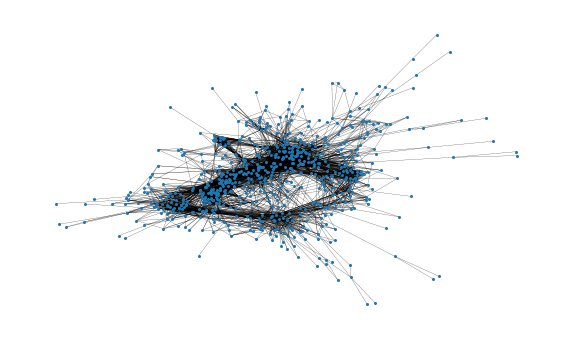

In [8]:
# Plot network
fig, ax = plt.subplots(1,figsize =(10,6))
nx.draw(G,ax=ax,pos=pos, node_size = 4,width = 0.2)

In [9]:
print(G)

Graph with 677 nodes and 6517 edges


# Full MSF

In [10]:
root = "/home/tc/OneDrive/Software/MSFiltration/experiments/results/real networks/"

In [11]:
# load ms results
with open(root + "ms_wiki_science.pkl", 'rb') as handle:
        ms_results = pickle.load(handle)

# initialise new MSF object and compute PH
msf = MSF()
msf.load_ms_results(ms_results)
msf.build_filtration()
msf.compute_persistence()

Building filtration ...


100%|██████████| 200/200 [05:42<00:00,  1.71s/it]


Computing persistence ... 


In [ ]:
# select optimal scales with nvi
identify_optimal_scales(msf.ms_results,criterion_threshold=0,window_size=20)
selected_scales_nvi = msf.log_times[msf.ms_results['selected_partitions']]
# plot nvi summary of ms
plotting.plot_scan(msf.ms_results)

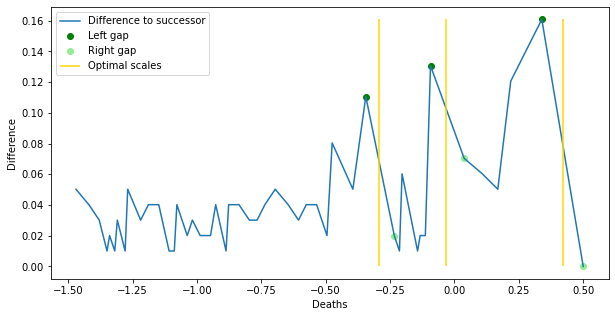

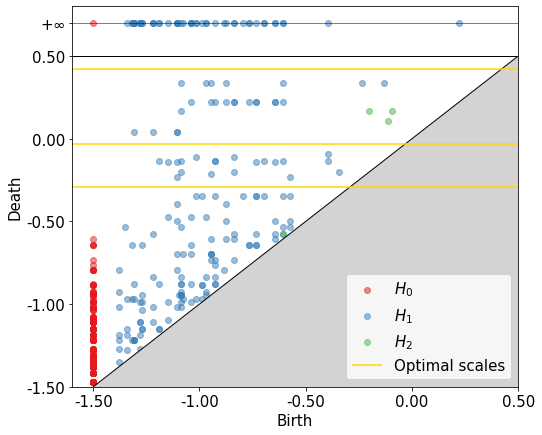

In [ ]:
# select optimal scales with ph
msf.select_scales(with_plot=True, threshold_abs=0,min_gap_width=0.105)
# plot persistence diagram with optimal scales
ax = msf.plot_persistence_diagram()

# Develop density based approach for scale selection

1. Get number of deaths per time (option to specify only certain homology groups)
2. Identify areas of low density
3. Select optimal scales as the left gaps of the low density area (these correspond to the partitions that resolve conflicts)

4. Integrate birth counts. A scale is bad if it has a high number of births.

In [ ]:
from msfiltration.msf_properties import *

In [ ]:
death_count = compute_combined_death_count(msf,[1,2])
birth_count = compute_combined_birth_count(msf,[1,2])

In [ ]:
window_size = 20
window = np.ones(window_size) / window_size

In [ ]:
# compute death density
death_total = np.sum(death_count)
death_density = np.convolve(death_count / death_total, window, "same")

# compute birth density
birth_total = np.sum(birth_count)
birth_density = birth_count / birth_total

In [ ]:
from scipy.signal import find_peaks

In [ ]:
# PARAM 1
height = 0#1-2/(death_total+birth_total)

In [ ]:
death_peaks, _ = find_peaks(1-death_density,height=height)
birth_peaks, _ = find_peaks(birth_density,height=height)

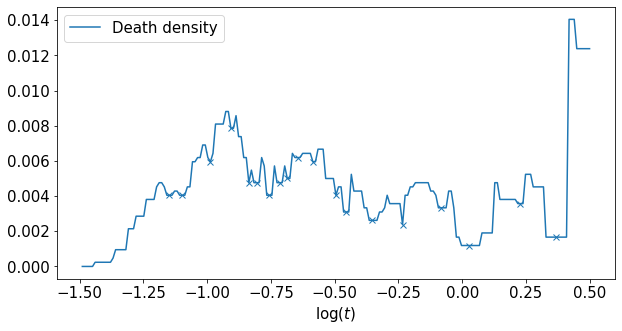

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times[1:],death_density[1:-1],label='Death density')
ax.plot(msf.log_times[death_peaks],death_density[death_peaks],'x',color='C0')
#ax.plot(msf.log_times[1:],birth_density[1:-1], ls = '--', label = 'Birth density',color='C1')
#ax.plot(msf.log_times[birth_peaks],birth_density[birth_peaks],'x',color='C1')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.show()

should we not concentrate on the peak directly? as these correspond always to the first partitions to resolve the conflicts ...

In [ ]:
# the last peak is selected
selected_scales = [death_peaks[-1]]

for i in range(len(death_peaks)-1,-1,-1):
    # only add the previous peak if it is not a direct neighbour
    if selected_scales[-1]-death_peaks[i] > 3:
        selected_scales.append(death_peaks[i])
    
selected_scales = np.sort(np.asarray(selected_scales))

In [ ]:
len(selected_scales)

17

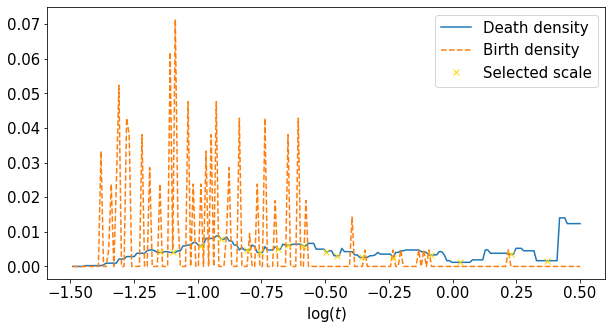

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times[1:],death_density[1:-1],label='Death density')
ax.plot(msf.log_times[1:],birth_density[1:-1], ls = '--', label = 'Birth density',color='C1')
ax.plot(msf.log_times[selected_scales],death_density[selected_scales],'x',label='Selected scale',color='gold')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.show()

In [ ]:
# # remove those death peaks that are smaller than the birth peaks
# for i in np.intersect1d(birth_peaks,selected_scales):
#     if birth_density[i] > death_density[i]:
#         selected_scales = np.delete(selected_scales,np.where(selected_scales==i)[0][0])

In [ ]:
# PARAM 2
max_birth_density = 3/birth_total

In [ ]:
# remove those death peaks that have positive birth density
selected_scales = selected_scales[birth_density[selected_scales]<=max_birth_density]

In [ ]:
len(selected_scales)

12

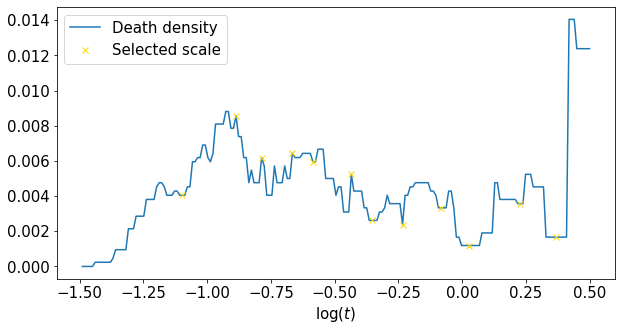

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times[1:],death_density[1:-1],label='Death density')
#ax.plot(msf.log_times[1:],birth_density[1:-1], ls = '--', label = 'Birth density',color='C1')
ax.plot(msf.log_times[selected_scales],death_density[selected_scales],'x',label='Selected scale',color='gold')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.show()

In [ ]:
height_low = 1/(death_total+birth_total)
death_peaks_low, _ = find_peaks(death_density,height=height_low)
birth_peaks_low, _ = find_peaks(birth_density,height=height_low)

In [ ]:
# as long as birth density is 0 move peaks to right
for i, s in enumerate(selected_scales):

    # compute first index to the right of s such that birth density bigger than threshold
    ind_no_birth = s+1+np.argmax(birth_density[s+1:]>max_birth_density)

    # obtain largest peak such that birth density is smaller than threshold
    if ind_no_birth > s+1:
        s_new = np.max(death_peaks_low[death_peaks_low<ind_no_birth])
        # replace peaks
        selected_scales[i] = s_new

selected_scales = np.unique(selected_scales)
    

In [ ]:
len(selected_scales)

12

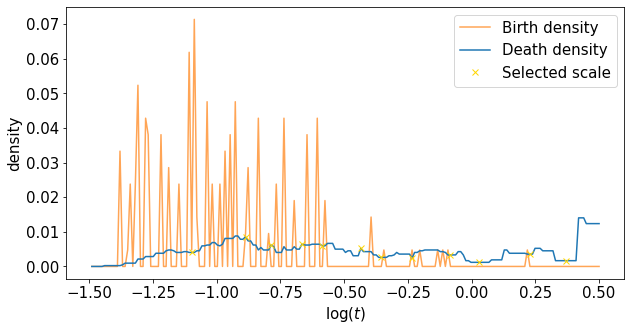

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times[1:],birth_density[1:-1], ls = '-', alpha=0.7,label = 'Birth density',color='C1')
ax.plot(msf.log_times[1:],death_density[1:-1],label='Death density')
ax.plot(msf.log_times[selected_scales],death_density[selected_scales],'x',label='Selected scale',color='gold')
ax.set(xlabel=r'$\log(t)$',ylabel='density')
ax.legend()
plt.show()

# Summary

<AxesSubplot:xlabel='Birth', ylabel='Death'>

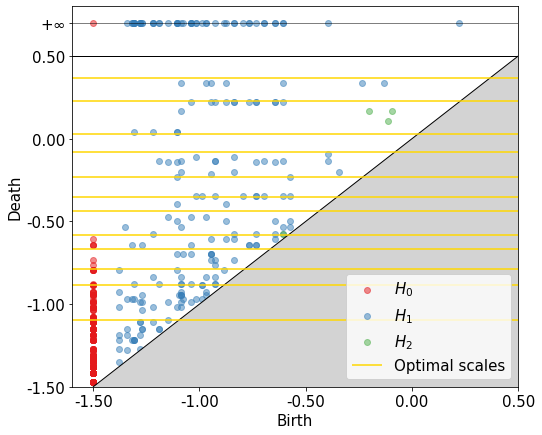

In [ ]:
msf.optimal_scales = selected_scales
msf.plot_persistence_diagram()

# Combined framework

# Other stuff

In [ ]:
death_widths = peak_widths(death_density[:-1], death_peaks, rel_height=1)
birth_widths = peak_widths(birth_density[:-1], birth_peaks, rel_height=1)

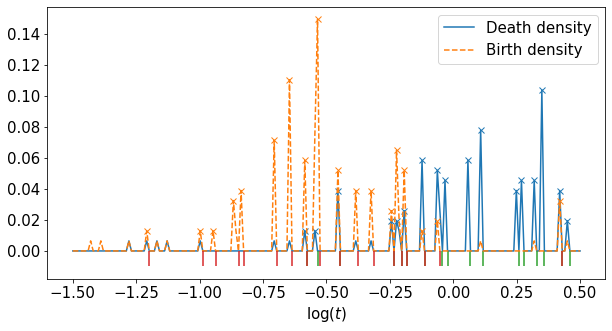

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times,death_density[:-1],label='Death density',color='C0')
plt.plot(msf.log_times[death_peaks],death_density[death_peaks],'x',color='C0')
ax.vlines(msf.log_times[np.asarray(death_widths[3],dtype='int')],ymin=-0.01,ymax=0, color="C2")
ax.plot(msf.log_times,birth_density[:-1], ls = '--', label = 'Birth density',color='C1')
plt.plot(msf.log_times[birth_peaks],birth_density[birth_peaks],'x',color='C1')
ax.vlines(msf.log_times[np.asarray(birth_widths[3],dtype='int')],ymin=-0.01,ymax=0, color="C3")
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.show()

# Comparison of $\beta_0$ and rank(Partition)

In [ ]:
# compute rank of partition matrix
rank = np.asarray([len(np.unique(msf.community_ids[i])) for i in range(len(msf.log_times))])
# compute beta_0
death_count_0 = compute_death_count(0)
beta_0 = np.sum(death_count_0)-np.cumsum(death_count_0) # CORRECT?

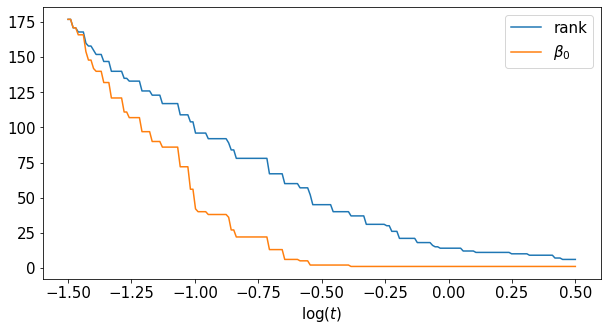

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(msf.log_times,rank, label = 'rank')
ax.plot(msf.log_times,beta_0[:-1], label = r'$\beta_0$')
ax.set(xlabel=r'$\log(t)$')
ax.legend()
plt.show()